# Week #5 Image Restoration

In [7]:
!wget -nc 'https://drive.google.com/uc?id=1Yox-XWM-PY9vFtDdzB_y_U3SK2paewwe' -O kitty.jpg
!wget -nc 'https://drive.google.com/uc?id=1bl9PxABh2h4irWStbiNNZl3RQxScl08u' -O nasa_image.png
!wget -nc 'https://drive.google.com/uc?id=1rqsQU7PbyrxpnheuzdMxbOVcFSaAps64' -O twins.jpg


File ‘kitty.jpg’ already there; not retrieving.
File ‘nasa_image.png’ already there; not retrieving.
File ‘twins.jpg’ already there; not retrieving.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from matplotlib.figure import Figure
from skimage import color, data, restoration
from scipy.signal import convolve2d
from math import log10, sqrt

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = np.max(original) # 255, 1
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

## Example #1 Noise

In [9]:
import cv2
from skimage.util import random_noise

img = cv2.imread("twins.jpg",0)

sp = random_noise(img, mode='s&p')
sp2 = random_noise(img, mode='s&p', amount = 0.2)

gauss = random_noise(img, mode='gaussian')
gauss2 = random_noise(img, mode='gaussian',var = 0.002, mean=0.5)

speckle = random_noise(img, mode='speckle')
speckle2 = random_noise(img, mode='speckle', var = 0.2 )



## Exercise #1 Investigate "noisy nasa_image" (img_pn) image using Fourier transform

(250, 333)


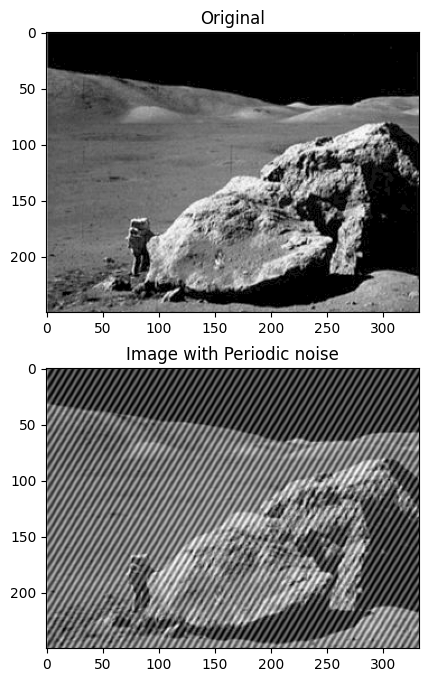

454.99204087556836


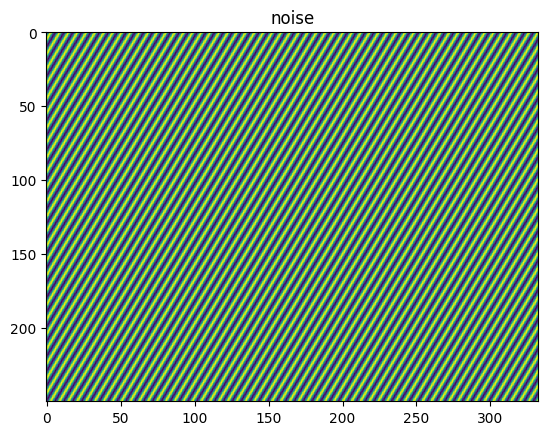

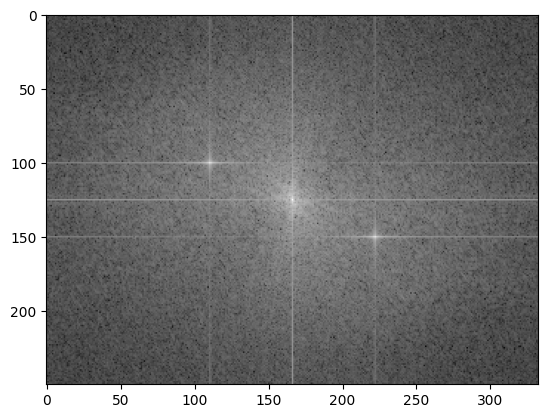

In [14]:
img = cv2.imread("nasa_image.png",0)


# strength
s = 100

nx, ny = img.shape
y = np.linspace(-nx/2,nx/2,nx)
x = np.linspace(-ny/2,ny/2,ny)
xv, yv = np.meshgrid(x,y)
p = s*(np.sin(np.pi*xv/3+np.pi*yv/5)+1.0)
print(img.shape)


img_pn = img.astype(float)+p

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (16,8))
fig.add_subplot(2,1,1), plt.imshow(img, cmap="gray"), plt.title('Original')
fig.add_subplot(2,1,2), plt.imshow(img_pn.astype(int), cmap="gray"), plt.title('Image with Periodic noise')
plt.show()

print(img_pn.max())
plt.imshow(p)
plt.title('noise')
plt.show()


# TO DO - Apply DFT with img_pn and analyze the results
# TO DO - Apply DFT with img_pn and analyze the results
img_pn_frq = np.fft.fft2(img_pn)
img_pn_frq = np.fft.fftshift(img_pn_frq)
plt.imshow(np.log(1+np.abs(img_pn_frq)),cmap='gray')
plt.show()


## Exercise #2 - Apply band reject to the img_pn

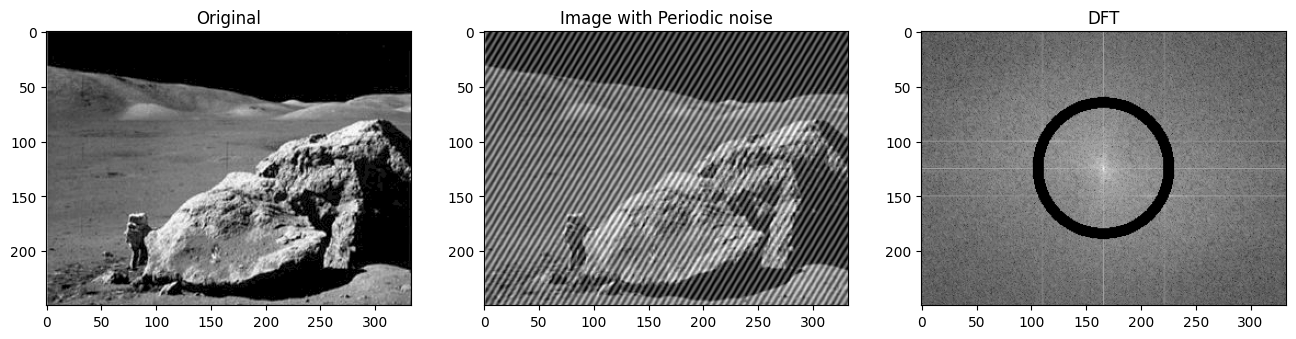

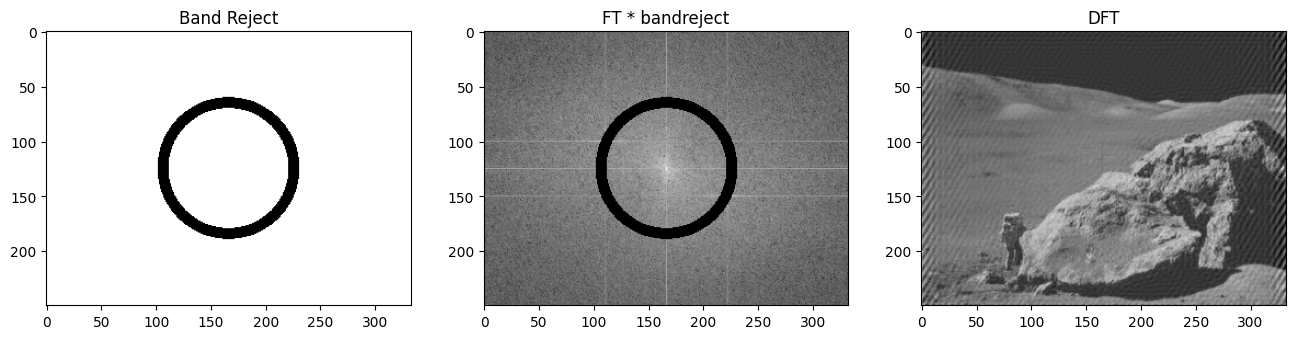

In [15]:
nx, ny = img.shape
y = np.linspace(-nx/2,nx/2,nx)
x = np.linspace(-ny/2,ny/2,ny)
xv, yv = np.meshgrid(x,y)
radiusCoor = np.sqrt(xv**2 + yv**2)

# TO DO - select appropriate radius here r = 60.42
r1 = radiusCoor <  55
r2 = radiusCoor >=  65
mask1 = np.ones([nx,ny])
bandReject = cv2.bitwise_or(r1.astype(np.uint8),r2.astype(np.uint8),mask=mask1.astype(np.uint8))


img_bandReject = bandReject * img_pn_frq
img_ft_filter_hp_spectrum = np.log(1+np.abs(img_bandReject))

f_ishift_br = np.fft.ifftshift(img_bandReject)
img_restored = np.fft.ifft2(f_ishift_br)
img_restored = np.abs(img_restored)


fig = plt.figure(figsize = (16,8))
fig.add_subplot(1,3,1), plt.imshow(img, cmap="gray"), plt.title('Original')
fig.add_subplot(1,3,2), plt.imshow(img_pn.astype(int), cmap="gray"), plt.title('Image with Periodic noise')

fig.add_subplot(1,3,3),plt.imshow(img_ft_filter_hp_spectrum.astype(np.uint8), cmap = 'gray')
plt.title('DFT')
plt.show()


fig = plt.figure(figsize = (16,8))
fig.add_subplot(1,3,1), plt.imshow(bandReject, cmap="gray"), plt.title('Band Reject')
fig.add_subplot(1,3,2), plt.imshow(img_ft_filter_hp_spectrum.astype(int), cmap="gray"), plt.title('FT * bandreject')

img_restored = (img_restored-img_restored.min())/(img_restored.max()-img_restored.min()) * 255

img_pn =  (img_pn-img_pn.min())/(img_pn.max()-img_pn.min()) * 255
fig.add_subplot(1,3,3),plt.imshow(img_restored,cmap='gray'),plt.title("Restored image")
plt.title('DFT')
plt.show()



## Exercise #3 - Apply notch filter to the img_pn

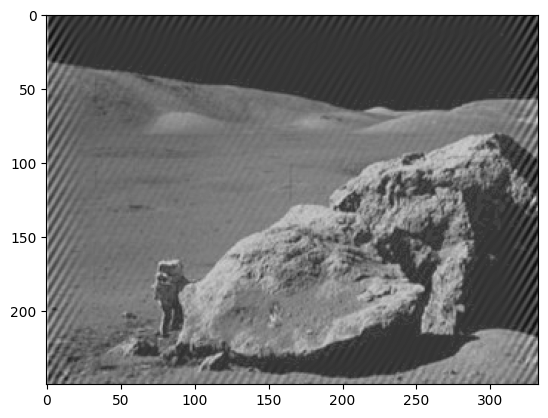

In [16]:

magnitude_spectrum = np.log(1 + np.abs(img_pn_frq))
im_notchFilter = img_pn_frq.copy()
im_notchFilter[95:105,105:115] = 0 # top left
im_notchFilter[145:155,220:225] = 0 # bottom right

img_ft_filter_nf_spectrum = np.log(1+np.abs(im_notchFilter))

f_ishift_nf = np.fft.ifftshift(im_notchFilter)
img_restored = np.fft.ifft2(f_ishift_nf)
img_restored = np.real(img_restored)
img_restored  = (img_restored - img_restored.min()) / (img_restored.max()-img_restored.min()) * 255

plt.imshow(img_restored,cmap='gray')
plt.show()


## Exercise #4 Wiener Filter

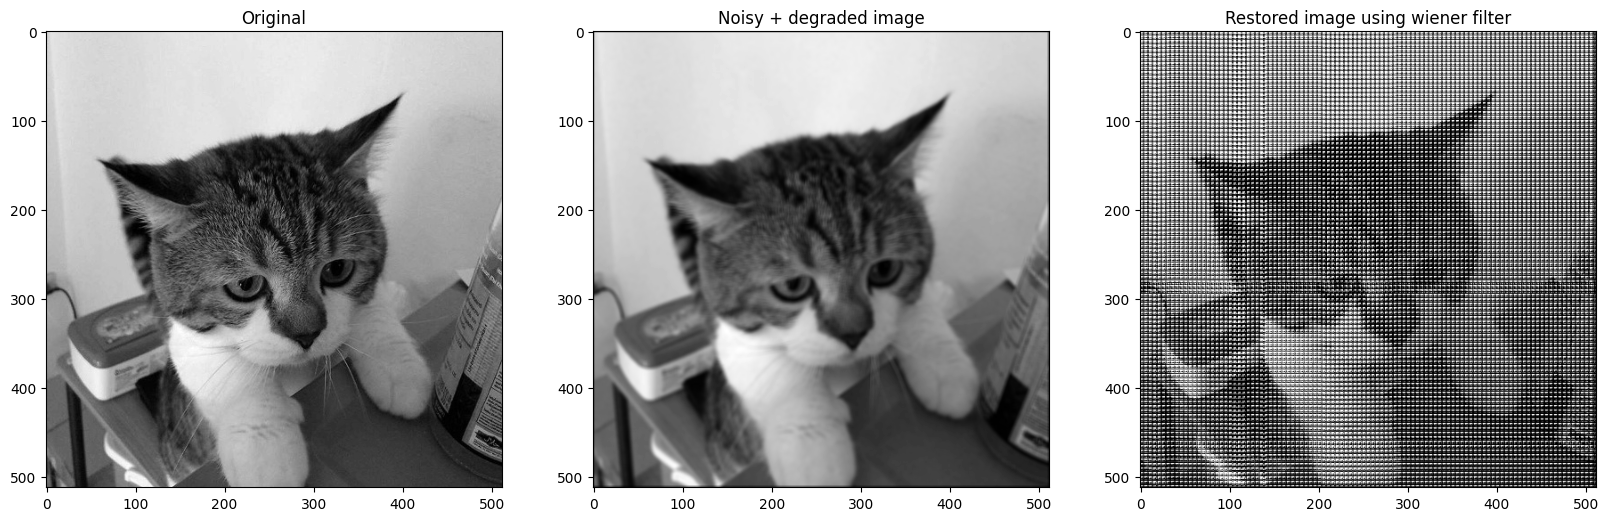

In [17]:
img = cv2.imread("kitty.jpg",0)

# K - ratio of power spectrum of noise (N(u,v)) and original image (F(u,v))
K = 0.007

# create a degraded image
degraded_fn = np.ones((5, 5)) / 25 # averaging filter 5x5
degraded_img = convolve2d(img, degraded_fn, 'same') # degraded image

# H(u,v) - FFT of degraded function
degraded_fn_pad = np.zeros((degraded_img.shape[0],degraded_img.shape[1]))
degraded_fn_pad[:degraded_fn.shape[0],:degraded_fn.shape[1]] = degraded_fn
degraded_fft = np.fft.fft2(degraded_fn_pad)

# G(u,v) - FFT of observed image
degraded_img_fft = np.fft.fft2(degraded_img)
restored_img = np.real(np.fft.ifft2(degraded_img_fft/degraded_fft)) #inverse filtering
# restored_img = restoration.wiener(degraded_img, degraded_fn,K)
restored_img[restored_img<0]  = 0
restored_img[restored_img>255] = 255

fig = plt.figure(figsize = (20,8))
fig.add_subplot(1,3,1),
plt.imshow(img, cmap="gray"), plt.title('Original')
fig.add_subplot(1,3,2),
plt.imshow(degraded_img, cmap="gray"), plt.title('Noisy + degraded image')
fig.add_subplot(1,3,3)
plt.imshow(restored_img,cmap = "gray"),plt.title("Restored image using wiener filter")
plt.show()

### Motion blur

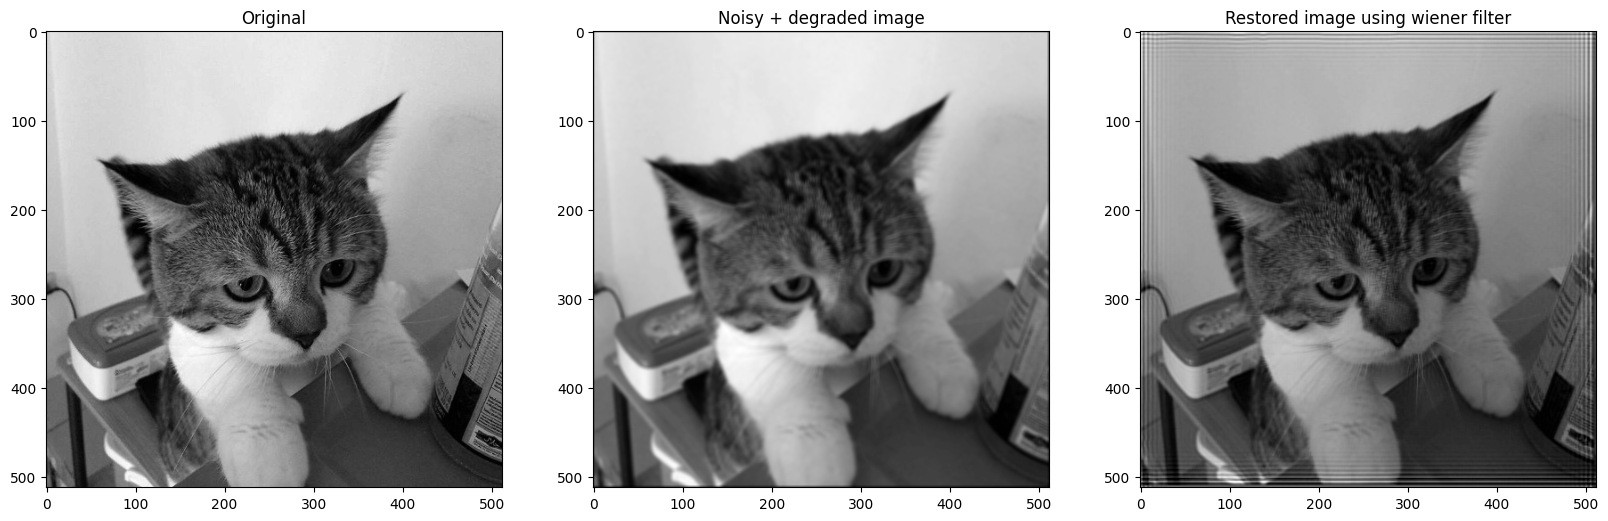

In [22]:
img = cv2.imread("kitty.jpg",0)

# K - ratio of power spectrum of noise (N(u,v)) and original image (F(u,v))
K = 0.009

# create a degraded image
degraded_fn = np.ones((5, 5)) / 25 # averaging filter 5x5
degraded_img = convolve2d(img, degraded_fn, 'same') # degraded image

# H(u,v) - FFT of degraded function
degraded_fn_pad = np.zeros((degraded_img.shape[0],degraded_img.shape[1]))
degraded_fn_pad[:degraded_fn.shape[0],:degraded_fn.shape[1]] = degraded_fn
degraded_fft = np.fft.fft2(degraded_fn_pad)

# G(u,v) - FFT of observed image
degraded_img_fft = np.fft.fft2(degraded_img)
restored_img = np.real(np.fft.ifft2(degraded_img_fft*np.conjugate(degraded_fft)/(np.abs(degraded_fft)**2 + K)))
# restored_img = restoration.wiener(degraded_img, degraded_fn,K)
restored_img[restored_img<0]  = 0
restored_img[restored_img>255] = 255

fig = plt.figure(figsize = (20,8))
fig.add_subplot(1,3,1),
plt.imshow(img, cmap="gray"), plt.title('Original')
fig.add_subplot(1,3,2),
plt.imshow(degraded_img, cmap="gray"), plt.title('Noisy + degraded image')
fig.add_subplot(1,3,3)
plt.imshow(restored_img,cmap = "gray"),plt.title("Restored image using wiener filter")
plt.show()